In [1]:
import os
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import chi2, logistic # logistic can be an alternative sigmoid
from scipy.optimize import curve_fit
import scienceplots
plt.style.use('science')

df_root_dir = 'tennis_abstract_dfs'
backup_root_dir = 'archive/tennis_abstract_dfs copy'
big_df_name = 'big_df.pkl'
poly_3_coeffs = [-3.59794087, 5.37889882, -0.8296175, 0.02421773]
poly_5_coeffs = [-2.917185, 4.41206716, -0.5201057, 0.01237278]
surfs = ['Clay', 'Grass', 'Hard']
swr_baseline = 63.5
rwr_baseline = 36.5

top_200_names = []
for file in tqdm(os.listdir(df_root_dir)):
    name = file[:-4]
    file_name = f'{df_root_dir}/{file}'
    p_df = pd.read_pickle(f'{df_root_dir}/{file}')
    latest_rank = p_df['rank'].iloc[-1]
    if latest_rank:
        latest_rank = int(latest_rank)
        if latest_rank < 200:
            top_200_names.append(name)
len(top_200_names)


100%|██████████| 380/380 [00:00<00:00, 1399.97it/s]


195

In [2]:
def restore_df(player):
    backup_path = f'{backup_root_dir}/{player}.pkl'
    file_path = f'{df_root_dir}/{player}.pkl'
    og = pd.read_pickle(backup_path)
    pd.to_pickle(og, file_path)

def restore_all_dfs(all_names):
    for name in tqdm(all_names):
        restore_df(name)

# restore_all_dfs(top_200_names)

In [3]:
processed_names = []
p_df = pd.read_pickle(f'{df_root_dir}/NovakDjokovic.pkl')
big_df = pd.DataFrame(
    {col: pd.Series(dtype=p_df[col].dtype) for col in p_df.columns} | {'formatted_player': pd.Series(dtype='str')}
)
name = ''
for player in tqdm(top_200_names):
    name = player
    file_path = f'{df_root_dir}/{player}.pkl'
    p_df = pd.read_pickle(file_path)
    alt_pdf = p_df.copy()
    alt_pdf['formatted_player'] = player
    # Filter out rows where 'formatted_opp' is in processed_names
    mask = ~alt_pdf['formatted_opp'].isin(processed_names)
    big_df = pd.concat([big_df, alt_pdf[mask]], ignore_index=True)
    processed_names.append(player)
big_df = big_df.reset_index(drop=True)
big_df = big_df.sort_values(by=['date', 'round_val', 'formatted_player', 'formatted_opp'], ascending=[True, False, True, True]).reset_index(drop=True)
resolution = 0.05
big_df['post_win_prob_rounded'] = (big_df['post_win_prob'] / resolution).round() * resolution
big_df['post_win_prob_rounded'] = big_df['post_win_prob_rounded'].replace({0.0: 0.01, 1.0: 0.99})
big_df_5 = big_df.copy()
big_df_5 = big_df_5[big_df_5['level'] == 'G']
big_df_3 = big_df.copy()
big_df_3 = big_df_3[big_df_3['level'] != 'G']
big_df.to_pickle(f'{big_df_name}')

  0%|          | 0/195 [00:00<?, ?it/s]

100%|██████████| 195/195 [00:01<00:00, 134.81it/s]


In [4]:
print(((big_df['post_win_prob'] < 0) | (big_df['post_win_prob'] > 1)).sum())
print(big_df[['serve_win_rate', 'return_win_rate']].isna().any(axis=1).sum())

0
0


In [5]:
def hosmer_lemeshow_goodness_of_fit(df, prob_col, actual_col, prob_col_name='predicted_prob_group'):
    """
    Performs a Hosmer-Lemeshow-like goodness-of-fit test.
    It groups data by the unique values present in the `prob_col`.
    This is suitable when `prob_col` contains probabilities that are already
    binned or rounded, and these rounded values are intended to define the groups.

    The null hypothesis is that the model is well-calibrated. A small p-value
    suggests poor calibration.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        prob_col (str): Name of the column with predicted probabilities.
                         Each unique value in this column defines a group.
                         Values should be between 0 and 1.
        actual_col (str): Name of the column with actual outcomes (0 or 1).

    Returns:
        pd.DataFrame: A table detailing observed vs. expected counts for each group.
        tuple: (H-statistic, p-value, degrees_of_freedom)
               Returns (np.nan, np.nan, df) for the statistics if the test 
               cannot be computed robustly (e.g., too few groups, or expected 
               counts of zero where observed are non-zero leading to infinite H).
    """
    # --- Input Validations ---
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame.")
    if prob_col not in df.columns:
        raise ValueError(f"Probability column '{prob_col}' not found in DataFrame.")
    if actual_col not in df.columns:
        raise ValueError(f"Actual outcome column '{actual_col}' not found in DataFrame.")
    
    # Create a copy to avoid SettingWithCopyWarning on original DataFrame
    df_copy = df[[prob_col, actual_col]].copy()

    try:
        df_copy[prob_col] = df_copy[prob_col].astype(float)
        df_copy[actual_col] = df_copy[actual_col].astype(int)
    except ValueError as e:
        raise ValueError(f"Could not convert '{prob_col}' or '{actual_col}' to required numeric types: {e}")

    if not df_copy[actual_col].isin([0, 1]).all():
        raise ValueError(f"Actual outcome column '{actual_col}' must contain only 0s and 1s.")
    if not ((df_copy[prob_col] >= 0) & (df_copy[prob_col] <= 1)).all():
        raise ValueError(f"Probability column '{prob_col}' must contain values between 0 and 1 inclusive.")

    # --- Grouping and Calculations ---
    # Group by the unique probability values.
    # `as_index=False` makes the grouping column a regular column.
    grouped_data = df_copy.groupby(prob_col, as_index=False).agg(
        total_count=(actual_col, 'count'),
        observed_wins=(actual_col, 'sum')
    )
    # Rename the probability column in the grouped_data for clarity in the output table
    grouped_data.rename(columns={prob_col: prob_col_name}, inplace=True)

    # Calculate expected wins (E_1k) and observed/expected losses (O_0k, E_0k)
    # E_1k = N_k * P_k (where P_k is the predicted_prob_group for that group)
    grouped_data['expected_wins'] = grouped_data['total_count'] * grouped_data[prob_col_name]
    grouped_data['observed_losses'] = grouped_data['total_count'] - grouped_data['observed_wins']
    # E_0k = N_k * (1 - P_k)
    grouped_data['expected_losses'] = grouped_data['total_count'] * (1 - grouped_data[prob_col_name])
    
    # --- Calculate H-statistic components ---
    # H = sum over groups [ ( (Observed_wins - Expected_wins)^2 / Expected_wins ) + 
    #                       ( (Observed_losses - Expected_losses)^2 / Expected_losses ) ]
    H_statistic_terms = []
    for _, row in grouped_data.iterrows():
        term_wins = 0.0
        # Check expected wins (denominator for wins term)
        if row['expected_wins'] < 1e-9:  # Effectively zero
            if row['observed_wins'] > 1e-9:  # Observed wins when none expected
                term_wins = np.inf  # Indicates severe model misfit for this group
        else:
            term_wins = ((row['observed_wins'] - row['expected_wins'])**2) / row['expected_wins']

        term_losses = 0.0
        # Check expected losses (denominator for losses term)
        if row['expected_losses'] < 1e-9:  # Effectively zero
            if row['observed_losses'] > 1e-9:  # Observed losses when none expected
                term_losses = np.inf  # Indicates severe model misfit for this group
        else:
            term_losses = ((row['observed_losses'] - row['expected_losses'])**2) / row['expected_losses']
        
        current_term_sum = term_wins + term_losses
        if np.isinf(current_term_sum):
            H_statistic = np.inf  # If any group's term is infinite, H is infinite
            break 
        H_statistic_terms.append(current_term_sum)
    else:  # This 'else' belongs to the 'for' loop: executed if loop completed without break
        H_statistic = sum(H_statistic_terms)

    num_groups = len(grouped_data)
    
    # --- Degrees of Freedom and p-value ---
    # Degrees of freedom: G - 2, where G is the number of groups.
    # Requires at least 3 groups for df > 0.
    if num_groups <= 2:
        print(f"Warning: Number of groups is {num_groups}. "
              "Hosmer-Lemeshow test typically requires > 2 groups for meaningful degrees of freedom.")
        # Still return calculated H, but p-value might be NaN or less meaningful
        df_degrees_of_freedom = max(0, num_groups - 2) # Avoid negative df
        if df_degrees_of_freedom == 0 and num_groups > 0 : # H might be non-zero but df=0
             p_value = 1.0 if np.abs(H_statistic) < 1e-9 else 0.0 # Heuristic for df=0
        else:
             p_value = np.nan
        return grouped_data, (H_statistic if num_groups > 0 else np.nan, p_value, df_degrees_of_freedom)

    df_degrees_of_freedom = num_groups - 2
    
    if np.isinf(H_statistic):
        p_value = 0.0 # Infinite H implies perfect misfit, p-value is 0
        print("Warning: H-statistic is infinite, likely due to observed events where P=0 (or vice-versa for P=1).")
    elif np.isnan(H_statistic): # Should ideally not happen if num_groups > 0
        p_value = np.nan
    else:
        p_value = chi2.sf(H_statistic, df_degrees_of_freedom) # Survival function (1 - CDF)
        
        # Add a small epsilon to total_count to prevent division by zero if a group somehow has 0 total_count
    summary_table_sorted = grouped_data.sort_values(by=prob_col_name).copy()
    summary_table_sorted['observed_win_rate'] = summary_table_sorted['observed_wins'] / (summary_table_sorted['total_count'] + 1e-9)
        
    return summary_table_sorted, (H_statistic, p_value, df_degrees_of_freedom)

In [6]:
def sigmoid_calibration_func(x, k, x0):
    """
    Sigmoid function for calibration: 1 / (1 + exp(-k*(x-x0)))
    k: steepness
    x0: midpoint
    """
    return 1 / (1 + np.exp(-k * (x - x0)))

In [7]:
def logistic_cdf_for_fit(x, loc, scale):
    """Wrapper for scipy.stats.logistic.cdf for use with curve_fit."""
    # Ensure scale is positive, as curve_fit might try negative values
    # A very small positive scale can lead to an extremely steep (almost step-like) function
    # which might be numerically unstable or not what is desired.
    # We can bound it during the fit or handle it here if necessary,
    # but curve_fit's `bounds` argument is generally preferred.
    if scale <= 1e-6: # Avoid zero or too small scale
        return np.full_like(x, np.nan if scale < 0 else (0.0 if np.mean(x) < loc else 1.0)) # Heuristic for bad scale
    return logistic.cdf(x, loc=loc, scale=scale)

In [8]:
def plot_calibration_curve(summary_table, prob_col_name='predicted_prob_group', show_trend=True, title_suffix="", poly_degree = 3):
    """
    Plots a calibration curve from the summary table of the Hosmer-Lemeshow test,
    including a sigmoid line of best fit by default.

    Args:
        summary_table (pd.DataFrame): The DataFrame returned by hosmer_lemeshow_goodness_of_fit.
        prob_col_name (str): The name of the column in summary_table representing
                             the predicted probability for the group.
        show_trend (bool): Whether to fit and plot a sigmoid trend line.
        title_suffix (str): Suffix to add to the plot title.
    """
    if not isinstance(summary_table, pd.DataFrame):
        print("Error: summary_table must be a pandas DataFrame.")
        return
    if prob_col_name not in summary_table.columns:
        print(f"Error: Probability column '{prob_col_name}' not found in summary_table.")
        return
    if 'observed_wins' not in summary_table.columns or 'total_count' not in summary_table.columns:
        print("Error: summary_table must contain 'observed_wins' and 'total_count' columns.")
        return
    
    predicted_probs = summary_table[prob_col_name]
    observed_rates = summary_table['observed_win_rate']

    plt.figure(figsize=(8, 6))
    plt.plot(predicted_probs, observed_rates, marker='o', linestyle='-', color='blue', label='Calibration Curve (Observed)')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Perfectly Calibrated')
    
    if show_trend and poly_degree > 0 and len(predicted_probs) >= poly_degree + 1:
        try:
            # Fit polynomial
            coeffs = np.polyfit(predicted_probs, observed_rates, poly_degree)
            print(f"Fitted polynomial coefficients in calibration curve: (degree {poly_degree}): {coeffs}")
            poly_func = np.poly1d(coeffs)

            # Generate smooth x values for plotting the polynomial
            x_smooth = np.linspace(min(0,predicted_probs.min()), max(1,predicted_probs.max()), 300) # Ensure range covers [0,1]
            y_smooth = poly_func(x_smooth)
            
            plt.plot(x_smooth, y_smooth, linestyle=':', color='green', label=f'Trend (Poly Degree {poly_degree})')
        except np.linalg.LinAlgError:
            print(f"Warning: Could not fit polynomial of degree {poly_degree}. "
                "This can happen with too few data points or collinearity. Skipping trend line.")
        except Exception as e:
            print(f"Warning: An error occurred while fitting/plotting polynomial trend: {e}. Skipping trend line.")

    # # Add sigmoid line of best fit if show_trend is True
    # if show_trend and len(predicted_probs) >= 2: # Need at least 2 points to fit a curve
    #     try:
    #         # Initial guesses for sigmoid parameters (k, x0)
    #         # loc is the midpoint (around 0.5), scale controls steepness (smaller is steeper)
    #         p0 = [0.5, 0.1] 
            
    #         # Bounds: loc typically between 0 and 1, scale must be positive and not too small.
    #         bounds = ([-0.5, 1e-3], [1.5, 1.0]) # Example bounds: loc can be outside [0,1], scale > 0. Adjust as needed.
            
    #         params, covariance = curve_fit(logistic_cdf_for_fit, 
    #                                        predicted_probs, 
    #                                        observed_rates, 
    #                                        p0=p0, 
    #                                        bounds=bounds, # Add bounds
    #                                        maxfev=5000)
            
    #         loc_fit, scale_fit = params
            
    #         # Generate smooth x values for plotting the logistic CDF
    #         x_smooth = np.linspace(min(0, predicted_probs.min()), max(1, predicted_probs.max()), 300)
    #         y_smooth = logistic.cdf(x_smooth, loc=loc_fit, scale=scale_fit) # Use logistic.cdf directly here
            
    #         plt.plot(x_smooth, y_smooth, linestyle=':', color='green', label=f'Trend (Logistic CDF Fit loc={loc_fit:.2f}, scale={scale_fit:.2f})')
        except RuntimeError:
            print("Warning: Could not fit sigmoid trend line (RuntimeError - optimal parameters not found). Skipping trend line.")
        except Exception as e:
            print(f"Warning: An error occurred while fitting/plotting sigmoid trend: {e}. Skipping trend line.")

    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Proportion of Wins')
    plt.title(f'Calibration Curve{title_suffix}')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.show()


Performing Hosmer-Lemeshow Goodness-of-Fit Test (Original Probabilities)...

--- Hosmer-Lemeshow Test Summary Table (Original) ---
    predicted_prob_group  total_count  observed_wins  expected_wins  \
0                   0.01          286              0           2.86   
1                   0.05          137              0           6.85   
2                   0.10          103              3          10.30   
3                   0.15           67              3          10.05   
4                   0.20           51              2          10.20   
5                   0.25           45              2          11.25   
6                   0.30           37              6          11.10   
7                   0.35           46             13          16.10   
8                   0.40           39             11          15.60   
9                   0.45           31             16          13.95   
10                  0.50           35             16          17.50   
11              

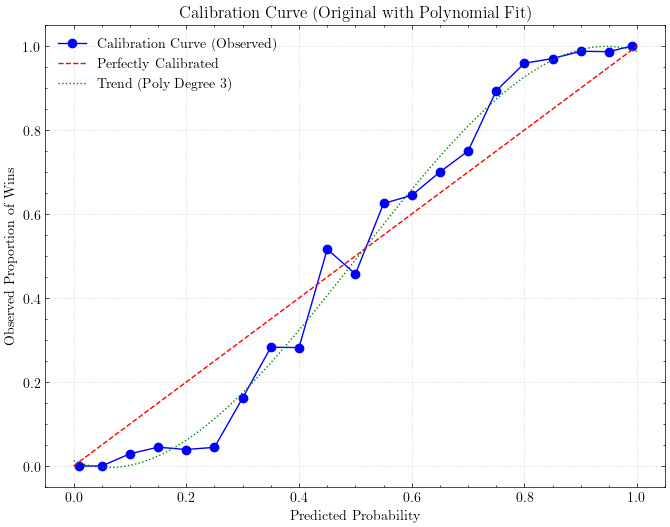


--- Applying Polynomial Calibration Transformation ---
Fitted Polynomial Coefficients for Calibration: [-2.917185    4.41206716 -0.5201057   0.01237278]

DataFrame with altered probabilities (first 5 rows):
    post_win_prob_rounded  post_win_prob_rounded_altered  result
11                   0.01                           0.01       0
12                   0.01                           0.01       0
13                   0.90                           0.99       1
14                   0.10                           0.01       0
15                   0.45                           0.40       0

Performing Hosmer-Lemeshow Goodness-of-Fit Test (Altered Probabilities)...

--- Hosmer-Lemeshow Test Summary Table (Altered) ---
Mean of (altered prob - result): -0.000281
Std of (altered prob - result): 0.235179
    predicted_prob_group  total_count  observed_wins  expected_wins  \
0                   0.01          559              4           5.59   
1                   0.05           79         

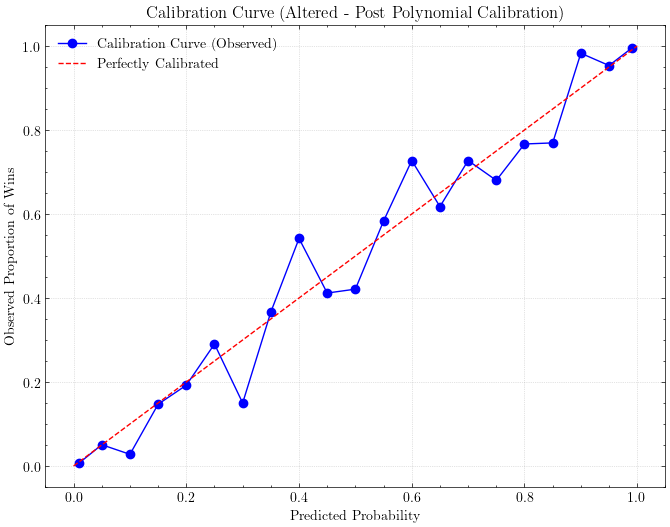

In [9]:
# Perform the test
matches_df = big_df_5
print("\nPerforming Hosmer-Lemeshow Goodness-of-Fit Test (Original Probabilities)...")
poly_degree_to_use = 3 # Define the degree for consistency
try:
    summary_table_orig, (H_orig, p_val_orig, df_val_orig) = hosmer_lemeshow_goodness_of_fit(
        matches_df, 
        'post_win_prob_rounded', 
        'result'
    )

    print("\n--- Hosmer-Lemeshow Test Summary Table (Original) ---")
    print(summary_table_orig)
    print("\n--- Test Statistics (Original) ---")
    if np.isnan(H_orig): print("H-statistic: Not reliably computed.")
    else: print(f"H-statistic: {H_orig:.4f}")
    if np.isnan(p_val_orig): print("p-value: Not reliably computed.")
    else: print(f"p-value: {p_val_orig:.4f}")
    print(f"Degrees of Freedom: {df_val_orig}")

    if not (np.isnan(p_val_orig) or np.isnan(H_orig)):
        if p_val_orig < 0.05: print("Original model shows evidence against good calibration.")
        else: print("Original model shows no significant evidence against good calibration.")
    
    if summary_table_orig is not None and not summary_table_orig.empty:
        print("\nDisplaying Calibration Curve (Original)...")
        plot_calibration_curve(summary_table_orig, show_trend=True, poly_degree=poly_degree_to_use, title_suffix=" (Original with Polynomial Fit)")
        
        # --- Step 2: Create altered probabilities and test them ---
        print("\n--- Applying Polynomial Calibration Transformation ---")
        
        # Re-fit polynomial based on the summary_table_orig to get the poly_func
        # This is done because poly_func is local to plot_calibration_curve
        # Ensure there are enough points for the chosen polynomial degree
        if len(summary_table_orig['predicted_prob_group']) >= poly_degree_to_use + 1:
            try:
                
                # Use observed_win_rate from summary_table_orig for fitting
                if 'observed_win_rate' not in summary_table_orig.columns:
                        summary_table_orig['observed_win_rate'] = summary_table_orig['observed_wins'] / (summary_table_orig['total_count'] + 1e-9)
                
                coeffs_calib = np.polyfit(summary_table_orig['predicted_prob_group'], 
                                            summary_table_orig['observed_win_rate'], 
                                            poly_degree_to_use)
                poly_func_calib = np.poly1d(coeffs_calib)
                print(f"Fitted Polynomial Coefficients for Calibration: {coeffs_calib}")


                # Apply transformation to the original probabilities in the main DataFrame
                matches_df['post_win_prob_rounded_altered_raw'] = poly_func_calib(
                    matches_df['post_win_prob']
                )

                # Clip probabilities to be within [0, 1]
                matches_df['post_win_prob_rounded_altered_clipped'] = np.clip(matches_df['post_win_prob_rounded_altered_raw'], 0, 1)
                
                # Round for grouping in the next HL test (e.g., to 2 decimal places)
                second_resolution = 0.05
                matches_df['post_win_prob_rounded_altered'] = (matches_df['post_win_prob_rounded_altered_clipped'] / second_resolution).round() * second_resolution
                matches_df['post_win_prob_rounded_altered'] = matches_df['post_win_prob_rounded_altered'].replace({0.0: 0.01, 1.0: 0.99})

                print("\nDataFrame with altered probabilities (first 5 rows):")
                print(matches_df[['post_win_prob_rounded', 'post_win_prob_rounded_altered', 'result']].head())

                # Perform HL test on altered probabilities
                print("\nPerforming Hosmer-Lemeshow Goodness-of-Fit Test (Altered Probabilities)...")
                summary_table_altered, (H_altered, p_val_altered, df_val_altered) = hosmer_lemeshow_goodness_of_fit(
                    matches_df, 
                    'post_win_prob_rounded_altered', 
                    'result'
                )
                print("\n--- Hosmer-Lemeshow Test Summary Table (Altered) ---")
                diff = matches_df['post_win_prob_rounded_altered'] - matches_df['result']
                mean_diff = diff.mean()
                std_diff = diff.std()
                print(f"Mean of (altered prob - result): {mean_diff:.6f}")
                print(f"Std of (altered prob - result): {std_diff:.6f}")
                print(summary_table_altered)
                print("\n--- Test Statistics (Altered) ---")
                if np.isnan(H_altered): print("H-statistic: Not reliably computed.")
                else: print(f"H-statistic: {H_altered:.4f}")
                if np.isnan(p_val_altered): print("p-value: Not reliably computed.")
                else: print(f"p-value: {p_val_altered:.4f}")
                print(f"Degrees of Freedom: {df_val_altered}")

                if not (np.isnan(p_val_altered) or np.isnan(H_altered)):
                    if p_val_altered < 0.05: print("Altered model shows evidence against good calibration., p = ", p_val_altered)
                    else: print("Altered model shows no significant evidence against good calibration.")
                
                if summary_table_altered is not None and not summary_table_altered.empty:
                    print("\nDisplaying Calibration Curve (Altered)...")
                    # For the altered curve, we show its raw calibration without fitting another trend on top
                    plot_calibration_curve(summary_table_altered, show_trend=False, title_suffix=" (Altered - Post Polynomial Calibration)") 

            except np.linalg.LinAlgError:
                print(f"Error: Could not fit calibration polynomial of degree {poly_degree_to_use}. "
                        "Skipping alteration step.")
            except Exception as e:
                print(f"An error occurred during probability alteration: {e}. Skipping alteration step.")
        else:
            print(f"Skipping alteration: Not enough unique probability groups in original summary table ({len(summary_table_orig['predicted_prob_group'])}) to fit polynomial of degree {poly_degree_to_use}.")


except ValueError as e:
    print(f"Error during initial test: {e}")
except TypeError as e:
    print(f"Error during initial test (type issue): {e}")


In [10]:
print(coeffs_calib)

[-2.917185    4.41206716 -0.5201057   0.01237278]


In [11]:
def analytic_set_prob_points(ps, pr):
 # --- Define common sub-expressions for readability and accuracy ---
    pr_minus_1 = pr - 1
    ps_minus_1 = ps - 1

    # pr-related common terms
    pr_term_1plus2pr = (1 + 2 * pr)
    pr_term_5plus4pr_minus2pr = (5 + 4 * (-2 + pr) * pr)  # 5 - 8pr + 4pr^2
    pr_term_1plus2pr_minus1pr = (1 + 2 * pr_minus_1 * pr)  # 1 - 2pr + 2pr^2
    pr_term_1plus4pr_sq = (1 + 4 * pr**2)
    pr_term_minus3plus2pr = (-3 + 2 * pr)
    pr_term_3minus2pr = (3 - 2 * pr)

    # ps-related common terms
    ps_term_1plus2ps = (1 + 2 * ps)
    ps_term_5plus4ps_minus2ps = (5 + 4 * (-2 + ps) * ps)  # 5 - 8ps + 4ps^2
    ps_term_1plus2ps_minus1ps = (1 + 2 * ps_minus_1 * ps)  # 1 - 2ps + 2ps^2
    ps_term_1plus4ps_sq = (1 + 4 * ps**2)
    ps_term_minus3plus2ps = (-3 + 2 * ps)
    ps_term_3minus2ps = (3 - 2 * ps)

    # --- Calculate the first 15 main terms of the numerator ---

    term1 = (
        4 * (pr_minus_1)**12 * pr**4 * pr_term_minus3plus2pr * pr_term_1plus2pr**3 *
        pr_term_5plus4pr_minus2pr * pr_term_1plus2pr_minus1pr**2 * pr_term_1plus4pr_sq**3 *
        ps**20 * ps_term_minus3plus2ps**5 * ps_term_5plus4ps_minus2ps**5 *
        ps_term_1plus2ps_minus1ps
    )

    term2 = (
        pr_minus_1**16 * pr**4 * pr_term_minus3plus2pr * pr_term_1plus2pr**4 *
        pr_term_5plus4pr_minus2pr * pr_term_1plus2pr_minus1pr * pr_term_1plus4pr_sq**4 *
        ps**20 * ps_term_minus3plus2ps**5 * ps_term_5plus4ps_minus2ps**5 *
        ps_term_1plus2ps_minus1ps
    )

    term3 = (
        3 * pr_term_3minus2pr**2 * pr_minus_1**4 * pr**8 * pr_term_1plus2pr *
        pr_term_5plus4pr_minus2pr**2 * pr_term_1plus2pr_minus1pr**3 * pr_term_1plus4pr_sq *
        ps_term_3minus2ps**4 * ps**16 * ps_term_5plus4ps_minus2ps**4 *
        ps_term_1plus2ps_minus1ps**2
    )

    term4 = (
        3 * pr_term_3minus2pr**2 * pr_minus_1**8 * pr**8 * pr_term_1plus2pr**2 *
        pr_term_5plus4pr_minus2pr**2 * pr_term_1plus2pr_minus1pr**2 * pr_term_1plus4pr_sq**2 *
        ps_term_3minus2ps**4 * ps**16 * ps_term_5plus4ps_minus2ps**4 *
        ps_term_1plus2ps_minus1ps**2
    )

    term5 = (
        pr**12 * pr_term_minus3plus2pr**3 * pr_term_5plus4pr_minus2pr**3 *
        pr_term_1plus2pr_minus1pr**3 * ps**12 * ps_term_minus3plus2ps**3 *
        ps_term_5plus4ps_minus2ps**3 * ps_term_1plus2ps_minus1ps**3
    )

    term6 = (
        24 * pr_term_3minus2pr**2 * pr_minus_1**8 * pr**8 * pr_term_1plus2pr**2 *
        pr_term_5plus4pr_minus2pr**2 * pr_term_1plus2pr_minus1pr**2 * pr_term_1plus4pr_sq**2 *
        ps_term_3minus2ps**4 * ps_minus_1**4 * ps**16 * ps_term_1plus2ps *
        ps_term_5plus4ps_minus2ps**4 * ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq
    )

    term7 = (
        20 * pr_term_3minus2pr**2 * pr_minus_1**12 * pr**8 * pr_term_1plus2pr**3 *
        pr_term_5plus4pr_minus2pr**2 * pr_term_1plus2pr_minus1pr * pr_term_1plus4pr_sq**3 *
        ps_term_3minus2ps**4 * ps_minus_1**4 * ps**16 * ps_term_1plus2ps *
        ps_term_5plus4ps_minus2ps**4 * ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq
    )

    term8 = (
        3 * pr**12 * pr_term_minus3plus2pr**3 * pr_term_5plus4pr_minus2pr**3 *
        pr_term_1plus2pr_minus1pr**3 * ps_minus_1**4 * ps**12 *
        ps_term_minus3plus2ps**3 * ps_term_1plus2ps * ps_term_5plus4ps_minus2ps**3 *
        ps_term_1plus2ps_minus1ps**2 * ps_term_1plus4ps_sq
    )

    term9 = (
        12 * pr_minus_1**4 * pr**12 * pr_term_minus3plus2pr**3 * pr_term_1plus2pr *
        pr_term_5plus4pr_minus2pr**3 * pr_term_1plus2pr_minus1pr**2 * pr_term_1plus4pr_sq *
        ps_minus_1**4 * ps**12 * ps_term_minus3plus2ps**3 * ps_term_1plus2ps *
        ps_term_5plus4ps_minus2ps**3 * ps_term_1plus2ps_minus1ps**2 * ps_term_1plus4ps_sq
    )

    term10 = (
        24 * pr_minus_1**4 * pr**12 * pr_term_minus3plus2pr**3 * pr_term_1plus2pr *
        pr_term_5plus4pr_minus2pr**3 * pr_term_1plus2pr_minus1pr**2 * pr_term_1plus4pr_sq *
        ps_minus_1**8 * ps**12 * ps_term_minus3plus2ps**3 * ps_term_1plus2ps**2 *
        ps_term_5plus4ps_minus2ps**3 * ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq**2
    )

    term11 = (
        60 * pr_minus_1**8 * pr**12 * pr_term_minus3plus2pr**3 * pr_term_1plus2pr**2 *
        pr_term_5plus4pr_minus2pr**3 * pr_term_1plus2pr_minus1pr * pr_term_1plus4pr_sq**2 *
        ps_minus_1**8 * ps**12 * ps_term_minus3plus2ps**3 * ps_term_1plus2ps**2 *
        ps_term_5plus4ps_minus2ps**3 * ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq**2
    )

    term12 = (
        6 * pr_term_3minus2pr**4 * pr**16 * pr_term_5plus4pr_minus2pr**4 *
        pr_term_1plus2pr_minus1pr**2 * ps_term_3minus2ps**2 * ps_minus_1**8 *
        ps**8 * ps_term_1plus2ps**2 * ps_term_5plus4ps_minus2ps**2 *
        ps_term_1plus2ps_minus1ps**2 * ps_term_1plus4ps_sq**2
    )

    term13 = (
        4 * pr_term_3minus2pr**4 * pr**16 * pr_term_5plus4pr_minus2pr**4 *
        pr_term_1plus2pr_minus1pr**2 * ps_term_3minus2ps**2 * ps_minus_1**12 *
        ps**8 * ps_term_1plus2ps**3 * ps_term_5plus4ps_minus2ps**2 *
        ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq**3
    )

    term14 = (
        40 * pr_term_3minus2pr**4 * pr_minus_1**4 * pr**16 * pr_term_1plus2pr *
        pr_term_5plus4pr_minus2pr**4 * pr_term_1plus2pr_minus1pr * pr_term_1plus4pr_sq *
        ps_term_3minus2ps**2 * ps_minus_1**12 * ps**8 * ps_term_1plus2ps**3 *
        ps_term_5plus4ps_minus2ps**2 * ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq**3
    )

    term15 = (
        5 * pr**20 * pr_term_minus3plus2pr**5 * pr_term_5plus4pr_minus2pr**5 *
        pr_term_1plus2pr_minus1pr * ps_minus_1**16 * ps**4 * ps_term_minus3plus2ps *
        ps_term_1plus2ps**4 * ps_term_5plus4ps_minus2ps * ps_term_1plus2ps_minus1ps *
        ps_term_1plus4ps_sq**4
    )

    sum_of_first_15_terms = (
        term1 + term2 + term3 + term4 + term5 + term6 + term7 + term8 +
        term9 + term10 + term11 + term12 + term13 + term14 + term15
    )

    # --- Calculate the complex fractional term ---

    # Denominator of the fraction part: (1 - ps + pr (-1 + 2 ps))
    frac_den_main = (1 - ps + pr * (-1 + 2 * ps))
    if frac_den_main == 0:
        raise ValueError("Division by zero: Denominator of the inner fraction is zero.")

    # Numerator Block 1 (the first large parenthesized block after 1/denominator)
    num_block1_term1 = (
        -((pr_minus_1)**20 * pr_term_1plus2pr**5 * pr_term_1plus4pr_sq**5 *
        ps**20 * ps_term_minus3plus2ps**5 * ps_term_5plus4ps_minus2ps**5)
    )

    num_block1_term2 = (
        -25 * (pr_minus_1)**16 * pr**4 * pr_term_minus3plus2pr * pr_term_1plus2pr**4 *
        pr_term_5plus4pr_minus2pr * pr_term_1plus4pr_sq**4 * ps_term_3minus2ps**4 *
        (ps_minus_1)**4 * ps**16 * ps_term_1plus2ps * ps_term_5plus4ps_minus2ps**4 *
        ps_term_1plus4ps_sq
    )

    num_block1_term3 = (
        -100 * pr_term_3minus2pr**2 * (pr_minus_1)**12 * pr**8 * pr_term_1plus2pr**3 *
        pr_term_5plus4pr_minus2pr**2 * pr_term_1plus4pr_sq**3 * (ps_minus_1)**8 *
        ps**12 * ps_term_minus3plus2ps**3 * ps_term_1plus2ps**2 *
        ps_term_5plus4ps_minus2ps**3 * ps_term_1plus4ps_sq**2
    )

    num_block1_term4 = (
        -100 * (pr_minus_1)**8 * pr**12 * pr_term_minus3plus2pr**3 * pr_term_1plus2pr**2 *
        pr_term_5plus4pr_minus2pr**3 * pr_term_1plus4pr_sq**2 * ps_term_3minus2ps**2 *
        (ps_minus_1)**12 * ps**8 * ps_term_1plus2ps**3 * ps_term_5plus4ps_minus2ps**2 *
        ps_term_1plus4ps_sq**3
    )

    num_block1_term5 = (
        -25 * pr_term_3minus2pr**4 * (pr_minus_1)**4 * pr**16 * pr_term_1plus2pr *
        pr_term_5plus4pr_minus2pr**4 * pr_term_1plus4pr_sq * (ps_minus_1)**16 *
        ps**4 * ps_term_minus3plus2ps * ps_term_1plus2ps**4 * ps_term_5plus4ps_minus2ps *
        ps_term_1plus4ps_sq**4
    )

    num_block1_term6 = (
        -pr**20 * pr_term_minus3plus2pr**5 * pr_term_5plus4pr_minus2pr**5 *
        (ps_minus_1)**20 * ps_term_1plus2ps**5 * ps_term_1plus4ps_sq**5
    )

    numerator_block1_sum = (
        num_block1_term1 + num_block1_term2 + num_block1_term3 +
        num_block1_term4 + num_block1_term5 + num_block1_term6
    )

    # Numerator Block 2 (the second large parenthesized block after 1/denominator)

    num_block2_term1 = (
        pr**4 * pr_term_minus3plus2pr * pr_term_5plus4pr_minus2pr *
        ps**4 * ps_term_minus3plus2ps * ps_term_5plus4ps_minus2ps *
        (1 - ps + pr * (-1 + 2 * ps))
    )

    # Inner part of num_block2_term2 (parenthesis before the long polynomial)
    num_block2_term2_inner_parens = (
        -((pr_minus_1)**4 * pr_term_1plus2pr * pr_term_1plus4pr_sq *
        ps**4 * ps_term_minus3plus2ps * ps_term_5plus4ps_minus2ps) -
        (pr**4 * pr_term_minus3plus2pr * pr_term_5plus4pr_minus2pr *
        (ps_minus_1)**4 * ps_term_1plus2ps * ps_term_1plus4ps_sq)
    )

    # Long polynomial part of num_block2_term2
    poly_term1 = (6 - 5 * ps) * ps**5
    poly_term2 = 15 * pr * ps_minus_1 * ps**4 * (-6 + 5 * ps)
    poly_term3 = -5 * pr**2 * ps_minus_1 * ps**3 * (60 + ps * (-141 + 70 * ps))
    poly_term4 = (
        5 * pr**6 * ps_minus_1 * (1 + 14 * ps_minus_1 * ps * (1 + 3 * ps_minus_1 * ps))
    )
    poly_term5 = (
        5 * pr**3 * ps_minus_1 * ps**2 * (-60 + ps * (295 + 28 * ps * (-14 + 5 * ps)))
    )
    poly_term6 = (
        -3 * pr**4 * ps_minus_1 * ps * (30 + ps * (-305 + 42 * ps * (20 + ps * (-19 + 5 * ps))))
    )
    poly_term7 = (
        pr**5 * ps_minus_1 * (-6 + ps * (159 + 14 * ps * (-64 + 3 * ps * (42 + 5 * (-6 + ps) * ps))))
    )

    long_polynomial_sum = (
        poly_term1 + poly_term2 + poly_term3 + poly_term4 +
        poly_term5 + poly_term6 + poly_term7
    )

    num_block2_term2 = (
        pr * ps * num_block2_term2_inner_parens * long_polynomial_sum
    )

    numerator_block2_sum = num_block2_term1 + num_block2_term2

    # Combine the fractional term
    fractional_term_value = (numerator_block1_sum * numerator_block2_sum) / frac_den_main

    # --- Calculate the overall result ---
    total_numerator = sum_of_first_15_terms + fractional_term_value

    # Overall denominator for the entire expression
    overall_denominator = pr_term_1plus2pr_minus1pr**6 * ps_term_1plus2ps_minus1ps**6
    if overall_denominator == 0:
        raise ValueError("Division by zero: Overall denominator is zero.")

    final_result = total_numerator / overall_denominator

    return final_result

In [12]:
def analytic_match_prob(ps, pr, sets = 3):
    p = analytic_set_prob_points(ps, pr)
    if sets == 3:
        prob = p**2 + 2 * (p**2)*(1-p) 
    elif sets == 5:
        prob = p**3 + 3 * (p**3)*(1-p) + 6 * (p**3)*(1-p)**2
    return prob
# poly_func = np.poly1d(coeffs_calib)
def poly_func(x, sets):
    coeffs = poly_3_coeffs if sets == 3 else poly_5_coeffs
    return np.poly1d(coeffs)(x)

In [13]:
big_df.shape

(11665, 141)

Num of matches: 2072


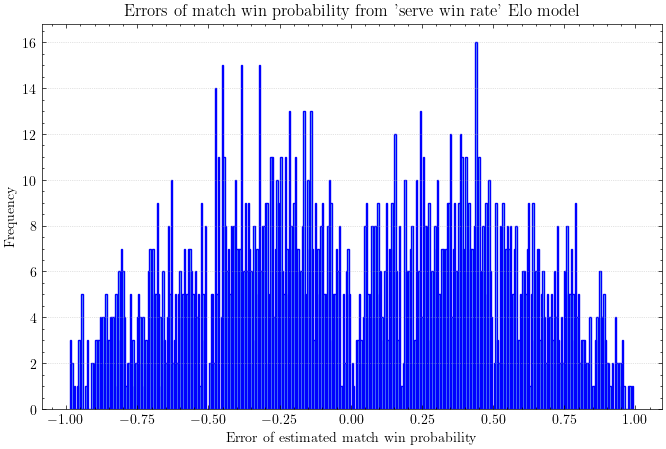

Mean Absolute Error (MAE): 0.421415
Fitted Normal Distribution for swr_err:
Mean (mu): 0.009574
Standard Deviation (std): 0.487787


In [28]:
from scipy.stats import norm
matches_df = big_df[(big_df['p_matchnum'] >= 100) & (big_df['o_matchnum'] >= 100)]
print(f'Num of matches: {len(matches_df)}')
results = matches_df['E_os'] - big_df['serve_win_rate']
results = matches_df.apply(lambda row: analytic_match_prob(row['E_os'], row['E_or'], sets=3) - row['result'], axis=1)

plt.figure(figsize=(8, 5))
plt.hist(results, bins=np.arange(results.min(), results.max() + 0.005, 0.005), color='skyblue', edgecolor='blue')
plt.xlabel('Error of estimated match win probability')
plt.ylabel('Frequency')
plt.title("Errors of match win probability from 'serve win rate' Elo model")
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.show()
# Drop NaNs for fitting
swr_err_values = results.dropna().values

# Fit to normal distribution
mu, std = norm.fit(swr_err_values)
mae = np.mean(np.abs(swr_err_values))
print(f"Mean Absolute Error (MAE): {mae:.6f}")

print(f"Fitted Normal Distribution for swr_err:")
print(f"Mean (mu): {mu:.6f}")
print(f"Standard Deviation (std): {std:.6f}")

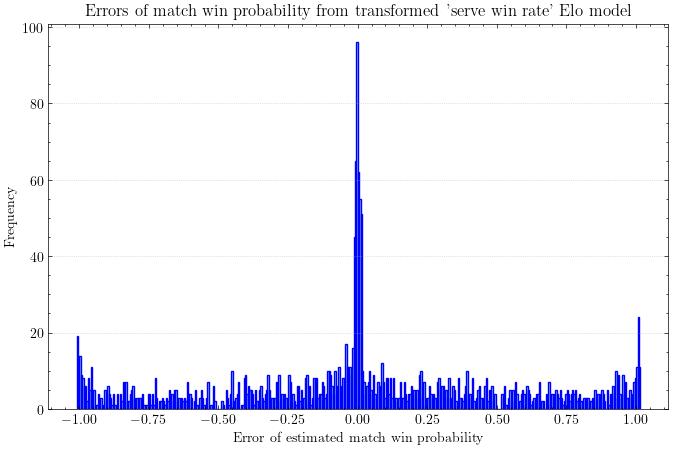

Mean Absolute Error (MAE): 0.392013
Fitted Normal Distribution for swr_err:
Mean (mu): 0.017913
Standard Deviation (std): 0.522696


In [29]:
from scipy.stats import norm

matches_df = big_df[(big_df['p_matchnum'] >= 100) & (big_df['o_matchnum'] >= 100)]
# results = big_df['E_os'] - big_df['serve_win_rate']
results = matches_df.apply(lambda row: poly_func(analytic_match_prob(row['E_os'], row['E_or'], sets=5 if row['level'] == 'G' else 3), sets=5 if row['level'] == 'G' else 3) - row['result'], axis=1)

plt.figure(figsize=(8, 5))
plt.hist(results, bins=np.arange(results.min(), results.max() + 0.005, 0.005), color='skyblue', edgecolor='blue')
plt.xlabel('Error of estimated match win probability')
plt.ylabel('Frequency')
plt.title("Errors of match win probability from transformed 'serve win rate' Elo model")
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.show()
# Drop NaNs for fitting
swr_err_values = results.dropna().values

# Fit to normal distribution
mu, std = norm.fit(swr_err_values)
# Calculate mean absolute error
mae = np.mean(np.abs(swr_err_values))
print(f"Mean Absolute Error (MAE): {mae:.6f}")

print(f"Fitted Normal Distribution for swr_err:")
print(f"Mean (mu): {mu:.6f}")
print(f"Standard Deviation (std): {std:.6f}")

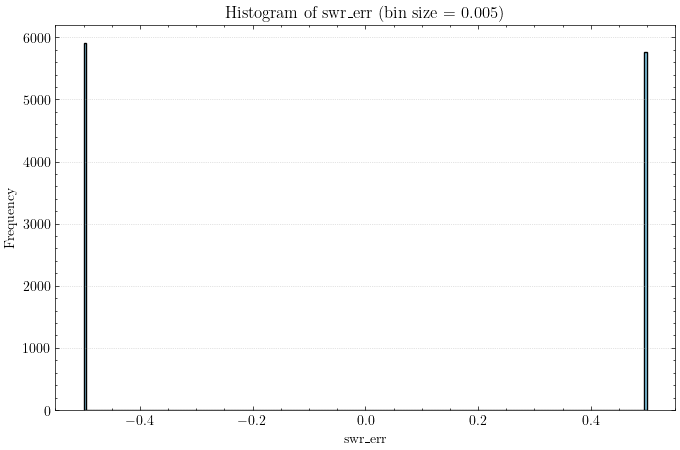

Fitted Normal Distribution for swr_err:
Mean (mu): -0.006044
Standard Deviation (std): 0.499963


In [16]:
from scipy.stats import norm

# results = big_df['E_os'] - big_df['serve_win_rate']
results = big_df.apply(lambda row: 0.5 - row['result'], axis=1)

plt.figure(figsize=(8, 5))
plt.hist(results, bins=np.arange(results.min(), results.max() + 0.005, 0.005), color='skyblue', edgecolor='black')
plt.xlabel('swr_err')
plt.ylabel('Frequency')
plt.title('Histogram of swr_err (bin size = 0.005)')
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.show()
# Drop NaNs for fitting
swr_err_values = results.dropna().values

# Fit to normal distribution
mu, std = norm.fit(swr_err_values)

print(f"Fitted Normal Distribution for swr_err:")
print(f"Mean (mu): {mu:.6f}")
print(f"Standard Deviation (std): {std:.6f}")

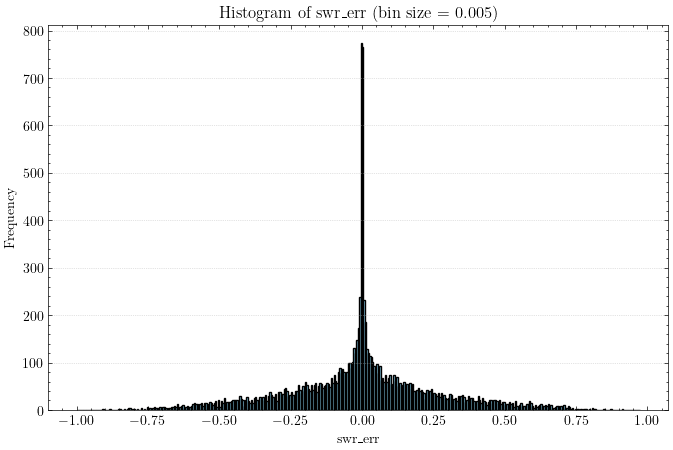

Fitted Normal Distribution for swr_err:
Mean (mu): -0.002743
Standard Deviation (std): 0.262987


In [17]:
from scipy.stats import norm

# def repeat_results(post_win_prob, sets=3)

results = big_df.apply(lambda row: row['post_win_prob'] - row['result'], axis=1)

plt.figure(figsize=(8, 5))
plt.hist(results, bins=np.arange(results.min(), results.max() + 0.005, 0.005), color='skyblue', edgecolor='black')
plt.xlabel('swr_err')
plt.ylabel('Frequency')
plt.title('Histogram of swr_err (bin size = 0.005)')
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.show()
# Drop NaNs for fitting
swr_err_values = results.dropna().values

# Fit to normal distribution
mu, std = norm.fit(swr_err_values)

print(f"Fitted Normal Distribution for swr_err:")
print(f"Mean (mu): {mu:.6f}")
print(f"Standard Deviation (std): {std:.6f}")

In [18]:
from scipy.stats import norm

# def repeat_results(post_win_prob, sets=3)

big_df['poly_func_err'] = big_df.apply(lambda row: poly_func(row['post_win_prob']) - row['result'], axis=1)

plt.figure(figsize=(8, 5))
plt.hist(results, bins=np.arange(results.min(), results.max() + 0.005, 0.005), color='skyblue', edgecolor='black')
plt.xlabel('swr_err')
plt.ylabel('Frequency')
plt.title('Histogram of swr_err (bin size = 0.005)')
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.show()
# Drop NaNs for fitting
swr_err_values = results.dropna().values

# Fit to normal distribution
mu, std = norm.fit(swr_err_values)

print(f"Fitted Normal Distribution for swr_err:")
print(f"Mean (mu): {mu:.6f}")
print(f"Standard Deviation (std): {std:.6f}")

TypeError: poly_func() missing 1 required positional argument: 'sets'

In [ ]:
big_df[(big_df['poly_func_err'] <= -1) | (big_df['poly_func_err'] >= 1)]

,date,tourn,surf,level,win/loss,rank,seed,entry,round,score,...,formatted_player,prev_10_mean_second_serve_win_rate,prev_10_median_second_serve_win_rate,prev_10_mean_second_return_win_rate,prev_10_median_second_return_win_rate,post_win_prob_rounded,post_win_prob_rounded_altered_raw,post_win_prob_rounded_altered_clipped,post_win_prob_rounded_altered,poly_func_err
1270,20210816,Luedenscheid CH,Clay,C,L,251,,,R32,1-6 7-6(5) 7-6(6),...,LukasKlein,0.536222,0.520525,0.455859,0.408333,0.90,1.010083,1.0,0.99,1.010083
1817,20211115,Tour Finals,Hard,F,L,5,5,,RR,2-6 7-5 7-6(5),...,AndreyRublev,NaN,NaN,NaN,NaN,0.85,1.002044,1.0,0.99,1.002044
2118,20220131,Cleveland CH,Hard,C,W,133,5,,R32,7-6(4) 6-3,...,JurijRodionov,0.529805,0.523201,0.472105,0.472222,0.10,-0.008046,0.0,0.01,-1.008046
2929,20220523,Roland Garros,Clay,G,L,212,,,Q1,4-6 6-4 6-4,...,JozefKovalik,0.514339,0.519231,0.500481,0.546584,0.95,1.003432,1.0,0.99,1.003432
3274,20220627,Wimbledon,Grass,G,W,26,22,,R64,7-6(7) 0-6 7-5 7-6(5),...,NikolozBasilashvili,0.545035,0.551117,0.493389,0.483333,0.10,-0.008153,0.0,0.01,-1.008153
4324,20221114,Sao Leopoldo CH,Clay,C,W,1363,,WC,R16,6-3 1-6 7-6(9),...,JoaoFonseca,NaN,NaN,NaN,NaN,0.10,-0.005570,0.0,0.01,-1.005570
4473,20230109,Adelaide 2,Hard,A,W,26,4,,SF,7-6(4) 3-6 6-3,...,RobertoBautistaAgut,NaN,NaN,NaN,NaN,0.10,-0.008225,0.0,0.01,-1.008225
6079,20230703,Wimbledon,Grass,G,W,84,,,R128,7-6(5) 1-6 6-3 6-4,...,AlexandreMuller,NaN,NaN,NaN,NaN,0.10,-0.001087,0.0,0.01,-1.001087
6378,20230731,Washington,Hard,A,L,86,,,R32,7-6(6) 1-6 6-4,...,ThanasiKokkinakis,NaN,NaN,NaN,NaN,0.85,1.001745,1.0,0.99,1.001745
7075,20231016,Antwerp,Hard,A,W,226,,Q,R32,0-6 6-3 7-6(4),...,GiovanniMpetshiPerricard,NaN,NaN,NaN,NaN,0.05,-0.001477,0.0,0.01,-1.001477


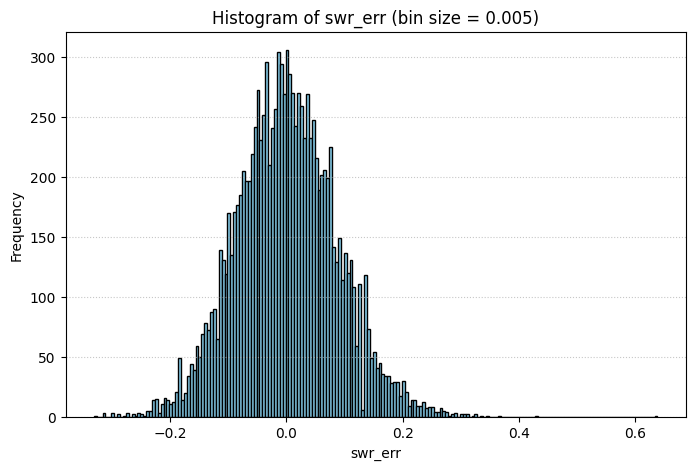

Fitted Normal Distribution for swr_err:
Mean (mu): 0.000011
Standard Deviation (std): 0.086306


In [ ]:
from scipy.stats import norm

# def repeat_results(post_win_prob, sets=3)

results = big_df.apply(lambda row: 0.634 - row['serve_win_rate'], axis=1)

plt.figure(figsize=(8, 5))
plt.hist(results, bins=np.arange(results.min(), results.max() + 0.005, 0.005), color='skyblue', edgecolor='black')
plt.xlabel('swr_err')
plt.ylabel('Frequency')
plt.title('Histogram of swr_err (bin size = 0.005)')
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.show()
# Drop NaNs for fitting
swr_err_values = results.dropna().values

# Fit to normal distribution
mu, std = norm.fit(swr_err_values)

print(f"Fitted Normal Distribution for swr_err:")
print(f"Mean (mu): {mu:.6f}")
print(f"Standard Deviation (std): {std:.6f}")

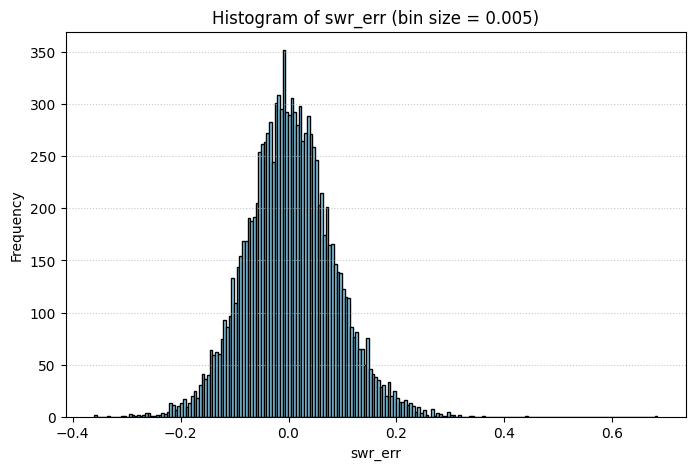

Fitted Normal Distribution for swr_err:
Mean (mu): 0.003109
Standard Deviation (std): 0.081663


In [ ]:
from scipy.stats import norm

# def repeat_results(post_win_prob, sets=3)

results = big_df.apply(lambda row: row['E_os'] - row['serve_win_rate'], axis=1)

plt.figure(figsize=(8, 5))
plt.hist(results, bins=np.arange(results.min(), results.max() + 0.005, 0.005), color='skyblue', edgecolor='black')
plt.xlabel('swr_err')
plt.ylabel('Frequency')
plt.title('Histogram of swr_err (bin size = 0.005)')
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.show()
# Drop NaNs for fitting
swr_err_values = results.dropna().values

# Fit to normal distribution
mu, std = norm.fit(swr_err_values)

print(f"Fitted Normal Distribution for swr_err:")
print(f"Mean (mu): {mu:.6f}")
print(f"Standard Deviation (std): {std:.6f}")